In [1]:
%%configure -f
{ "conf":{
"spark.pyspark.virtualenv.enabled": "false"
}}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1587047662657_0007,pyspark,idle,Link,Link,


In [2]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.window import Window
from pyspark.sql import functions as F

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1587047662657_0008,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
df_fairfax_beds = spark.sql("""select sum(num_staffed_beds) as total_num_staffed_beds, 
sum(adult_icu_beds) as total_adult_icu_beds, 
from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date_collected from 
covid19.rearc_us_hospital_beds_daily 
where year = '2020' and month = '04' 
and state_name = 'Virginia' and county_name like 'Fairfax%'
group by year,month,day
""")
df_fairfax_beds.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+--------------------+-------------------+
|total_num_staffed_beds|total_adult_icu_beds|     date_collected|
+----------------------+--------------------+-------------------+
|                  2581|                 336|2020-04-15 00:00:00|
|                  2581|                 336|2020-04-14 00:00:00|
|                  2581|                 336|2020-04-16 00:00:00|
|                  2581|                 336|2020-04-17 00:00:00|
+----------------------+--------------------+-------------------+

In [4]:
df_fairfax = spark.sql("""select max(confirmed) as numConfirmed, max(deaths) as numDeaths, 
case when (admin2 = 'Fairfax City' or admin2 = 'Falls Church') then 'Fairfax' else admin2 END as county, 
province_state,
from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date_collected
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' ) and 
( admin2 = 'Fairfax' or admin2 = 'Fairfax City' or admin2 = 'Falls Church' ) 
group by county,province_state, year, month, day
order by unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')""")
df_fairfax.show(df_fairfax.count(),False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+-------+--------------+-------------------+
|numConfirmed|numDeaths|county |province_state|date_collected     |
+------------+---------+-------+--------------+-------------------+
|31          |1        |Fairfax|Virginia      |2020-03-22 00:00:00|
|43          |1        |Fairfax|Virginia      |2020-03-23 00:00:00|
|46          |1        |Fairfax|Virginia      |2020-03-24 00:00:00|
|76          |1        |Fairfax|Virginia      |2020-03-25 00:00:00|
|79          |1        |Fairfax|Virginia      |2020-03-26 00:00:00|
|124         |1        |Fairfax|Virginia      |2020-03-27 00:00:00|
|156         |2        |Fairfax|Virginia      |2020-03-28 00:00:00|
|188         |2        |Fairfax|Virginia      |2020-03-29 00:00:00|
|224         |2        |Fairfax|Virginia      |2020-03-30 00:00:00|
|244         |2        |Fairfax|Virginia      |2020-03-31 00:00:00|
|288         |2        |Fairfax|Virginia      |2020-04-01 00:00:00|
|328         |2        |Fairfax|Virginia      |2

In [5]:
%spark -o df_fairfax_beds

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
%spark -o df_fairfax

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_fairfax_joined = df_fairfax.join(df_fairfax_beds, on=["date_collected"], how='left')
df_fairfax_joined_ordered = df_fairfax_joined.orderBy("date_collected")
df_fairfax_joined_ordered.show(df_fairfax_joined_ordered.count(),False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+---------+-------+--------------+----------------------+--------------------+
|date_collected     |numConfirmed|numDeaths|county |province_state|total_num_staffed_beds|total_adult_icu_beds|
+-------------------+------------+---------+-------+--------------+----------------------+--------------------+
|2020-03-22 00:00:00|31          |1        |Fairfax|Virginia      |null                  |null                |
|2020-03-23 00:00:00|43          |1        |Fairfax|Virginia      |null                  |null                |
|2020-03-24 00:00:00|46          |1        |Fairfax|Virginia      |null                  |null                |
|2020-03-25 00:00:00|76          |1        |Fairfax|Virginia      |null                  |null                |
|2020-03-26 00:00:00|79          |1        |Fairfax|Virginia      |null                  |null                |
|2020-03-27 00:00:00|124         |1        |Fairfax|Virginia      |null                  |null          

In [8]:
%spark -o df_fairfax_joined_ordered

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
%local
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 1440x720 with 0 Axes>

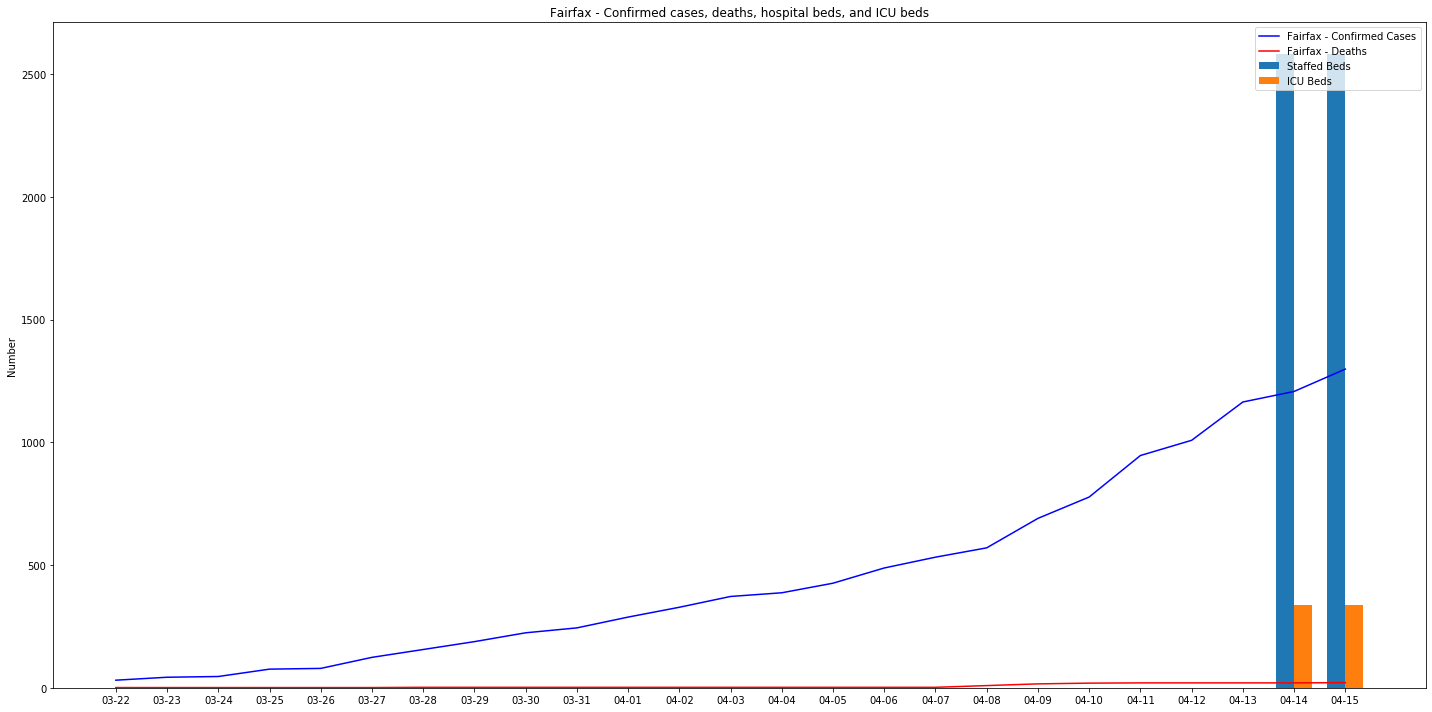

In [10]:
%local
import numpy as np
plt.figure(figsize=(20,10))
width = 0.35

x_list = df_fairfax_joined_ordered['date_collected'].tolist()
x_list_map = map(lambda x: x.strftime("%m-%d"), x_list)
x_list_dt = list(x_list_map)
x = np.arange(len(x_list_dt))

y_list_numConfirmed = df_fairfax_joined_ordered['numConfirmed'].tolist()
y_list_total_num_staffed_beds = df_fairfax_joined_ordered['total_num_staffed_beds'].tolist()
y_list_total_adult_icu_beds = df_fairfax_joined_ordered['total_adult_icu_beds'].tolist()
y_list_numDeaths = df_fairfax_joined_ordered['numDeaths'].tolist()

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, y_list_total_num_staffed_beds, width, label='Staffed Beds')
rects2 = ax.bar(x + width/2, y_list_total_adult_icu_beds, width, label='ICU Beds')

ax.set_xticks(x)
ax.set_xticklabels(x_list_dt)
ax.set_ylabel('Number')
ax.set_title("Fairfax - Confirmed cases, deaths, hospital beds, and ICU beds")
ax.legend()
fig.tight_layout()


plt.plot(x_list_dt, y_list_numConfirmed, label="Fairfax - Confirmed Cases",color='blue')
plt.plot(x_list_dt, y_list_numDeaths, label="Fairfax - Deaths",color='red')

plt.text
plt.legend()
plt.show()

In [11]:
df_dmv_beds = spark.sql("""select sum(num_staffed_beds) as total_num_staffed_beds, 
sum(adult_icu_beds) as total_adult_icu_beds, case when county_name = 'Fairfax County' then 'Fairfax' else county_name END as county_name,  
from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date_collected from 
covid19.rearc_us_hospital_beds_daily 
where year = '2020' and month = '04' 
and ( state_name = 'Virginia' and 
( county_name like 'Falls%' or county_name like 'Fairfax%' or county_name like 'Arlington%' or county_name like 'Alexandria%' or
county_name like 'Loudoun%') ) or 
( state_name = 'Maryland' and county_name like 'Montgomery%' ) or 
( state_name = 'District of Columbia' )
group by year,month,day,county_name 
order by county_name,date_collected""")
df_dmv_beds.show(df_dmv_beds.count(),False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+--------------------+--------------------+-------------------+
|total_num_staffed_beds|total_adult_icu_beds|county_name         |date_collected     |
+----------------------+--------------------+--------------------+-------------------+
|339                   |40                  |Alexandria          |2020-04-14 00:00:00|
|339                   |40                  |Alexandria          |2020-04-15 00:00:00|
|339                   |40                  |Alexandria          |2020-04-16 00:00:00|
|339                   |40                  |Alexandria          |2020-04-17 00:00:00|
|305                   |32                  |Arlington           |2020-04-14 00:00:00|
|305                   |32                  |Arlington           |2020-04-15 00:00:00|
|305                   |32                  |Arlington           |2020-04-16 00:00:00|
|305                   |32                  |Arlington           |2020-04-17 00:00:00|
|3077                  |407                

In [12]:
df_dmv = spark.sql("""select max(confirmed) as numConfirmed, max(deaths) as numDeaths, 
case when (admin2 = 'Fairfax City' or admin2 = 'Falls Church') then 'Fairfax' else admin2 END as county,
province_state,
from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')) as date_posted
from covid19.jhu_daily_new
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' and 
( admin2 like 'Fairfax%' or admin2 like 'Arlington%' or admin2 like 'Alexandria%' or
admin2 like 'Loudoun%') ) or 
( province_state = 'Maryland' and admin2 like 'Montgomery%' ) or 
( province_state = 'District of Columbia' )
group by county,province_state,date_posted
order by from_unixtime(unix_timestamp(concat(year,'-',month,'-',day),'yyyy-MM-dd')), county""")
df_dmv.show(df_dmv.count(),False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+--------------------+--------------------+-------------------+
|numConfirmed|numDeaths|county              |province_state      |date_posted        |
+------------+---------+--------------------+--------------------+-------------------+
|5           |0        |Alexandria          |Virginia            |2020-03-22 00:00:00|
|26          |0        |Arlington           |Virginia            |2020-03-22 00:00:00|
|102         |2        |District of Columbia|District of Columbia|2020-03-22 00:00:00|
|31          |1        |Fairfax             |Virginia            |2020-03-22 00:00:00|
|15          |0        |Loudoun             |Virginia            |2020-03-22 00:00:00|
|83          |1        |Montgomery          |Maryland            |2020-03-22 00:00:00|
|6           |0        |Alexandria          |Virginia            |2020-03-23 00:00:00|
|34          |0        |Arlington           |Virginia            |2020-03-23 00:00:00|
|120         |2        |District of Columbi

In [13]:
df_dmv_joined = df_dmv.join(df_dmv_beds, (df_dmv.date_posted==df_dmv_beds.date_collected)&(df_dmv.county == df_dmv_beds.county_name),'left')
#df_dmv_joined.show()
df_dmv_joined_ordered = df_dmv_joined.orderBy("date_posted","county")
df_dmv_joined_ordered.show(df_dmv_joined_ordered.count(),False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+---------+--------------------+--------------------+-------------------+----------------------+--------------------+--------------------+-------------------+
|numConfirmed|numDeaths|county              |province_state      |date_posted        |total_num_staffed_beds|total_adult_icu_beds|county_name         |date_collected     |
+------------+---------+--------------------+--------------------+-------------------+----------------------+--------------------+--------------------+-------------------+
|5           |0        |Alexandria          |Virginia            |2020-03-22 00:00:00|null                  |null                |null                |null               |
|26          |0        |Arlington           |Virginia            |2020-03-22 00:00:00|null                  |null                |null                |null               |
|102         |2        |District of Columbia|District of Columbia|2020-03-22 00:00:00|null                  |null                |null      

In [14]:
df_counties = spark.sql("""select case when ( admin2 = 'Fairfax City' or admin2 = 'Falls Church' ) then 'Fairfax' 
else admin2 end as county_name 
from covid19.jhu_daily_new 
where year='2020' and int(month) > 2
and country_region = 'US' and 
( province_state = 'Virginia' and 
( admin2 like 'Fall%' or admin2 like 'Fairfax%' or admin2 like 'Arlington%' or admin2 like 'Alexandria%' or
admin2 like 'Loudoun%') ) or 
( province_state = 'Maryland' and admin2 like 'Montgomery%' ) or 
( province_state = 'District of Columbia' )
group by county_name
order by county_name
""")
df_counties.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|         county_name|
+--------------------+
|          Alexandria|
|           Arlington|
|District of Columbia|
|             Fairfax|
|             Loudoun|
|          Montgomery|
+--------------------+

In [15]:
%spark -o df_dmv_joined_ordered

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
%spark -o df_counties

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

25
25


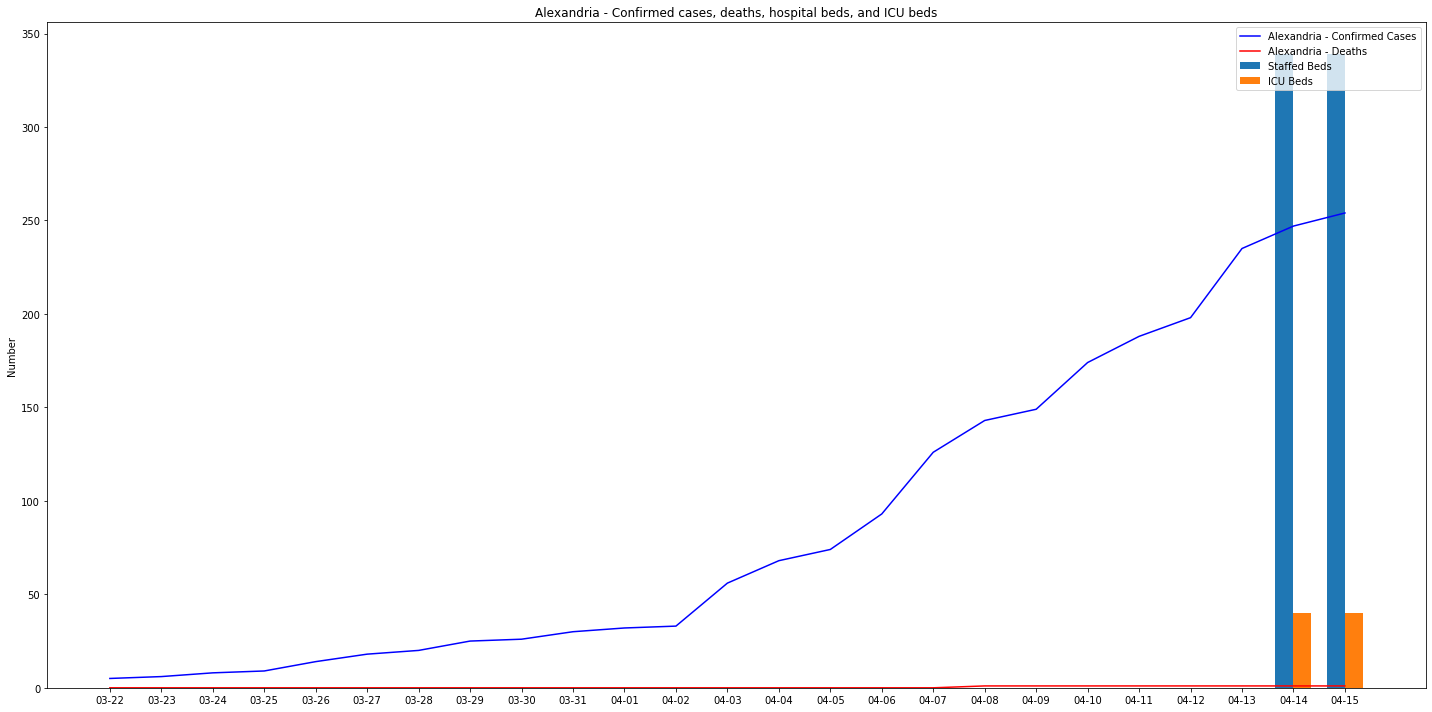

25
25


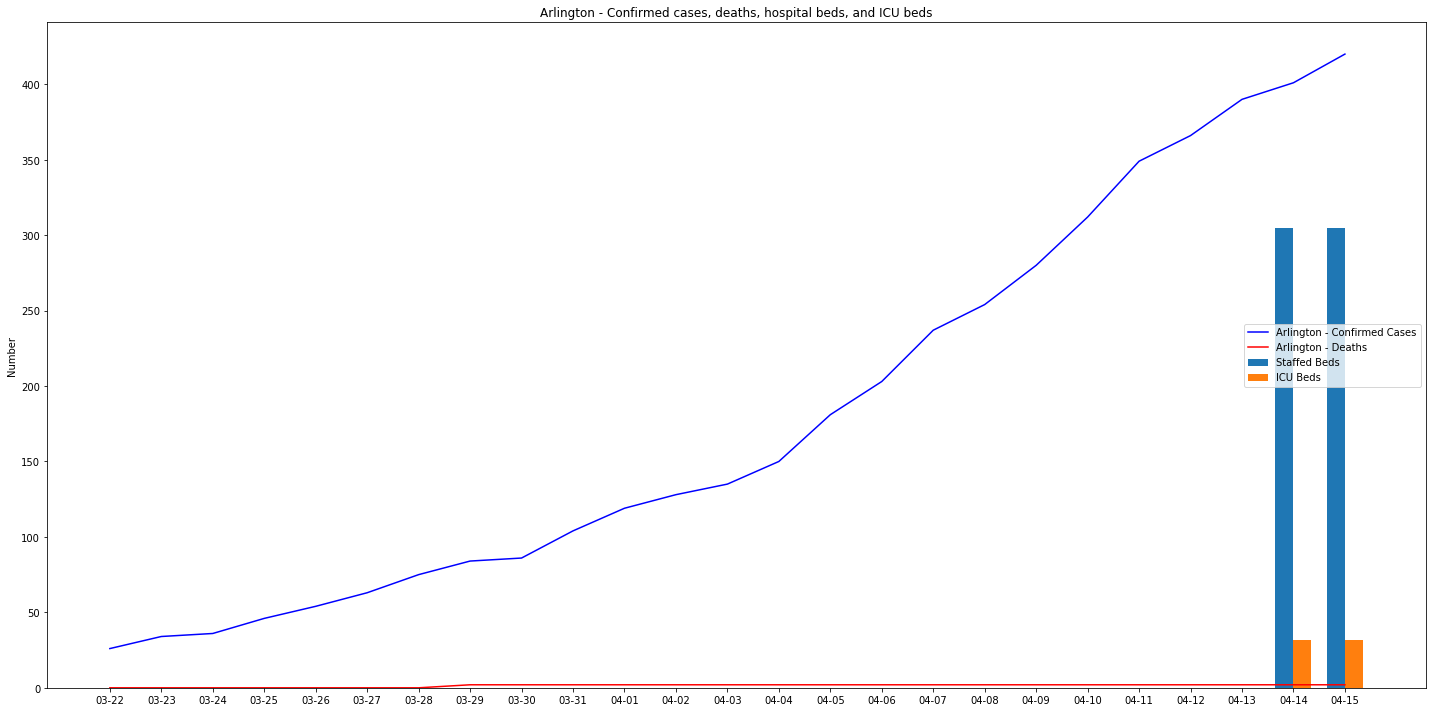

25
25


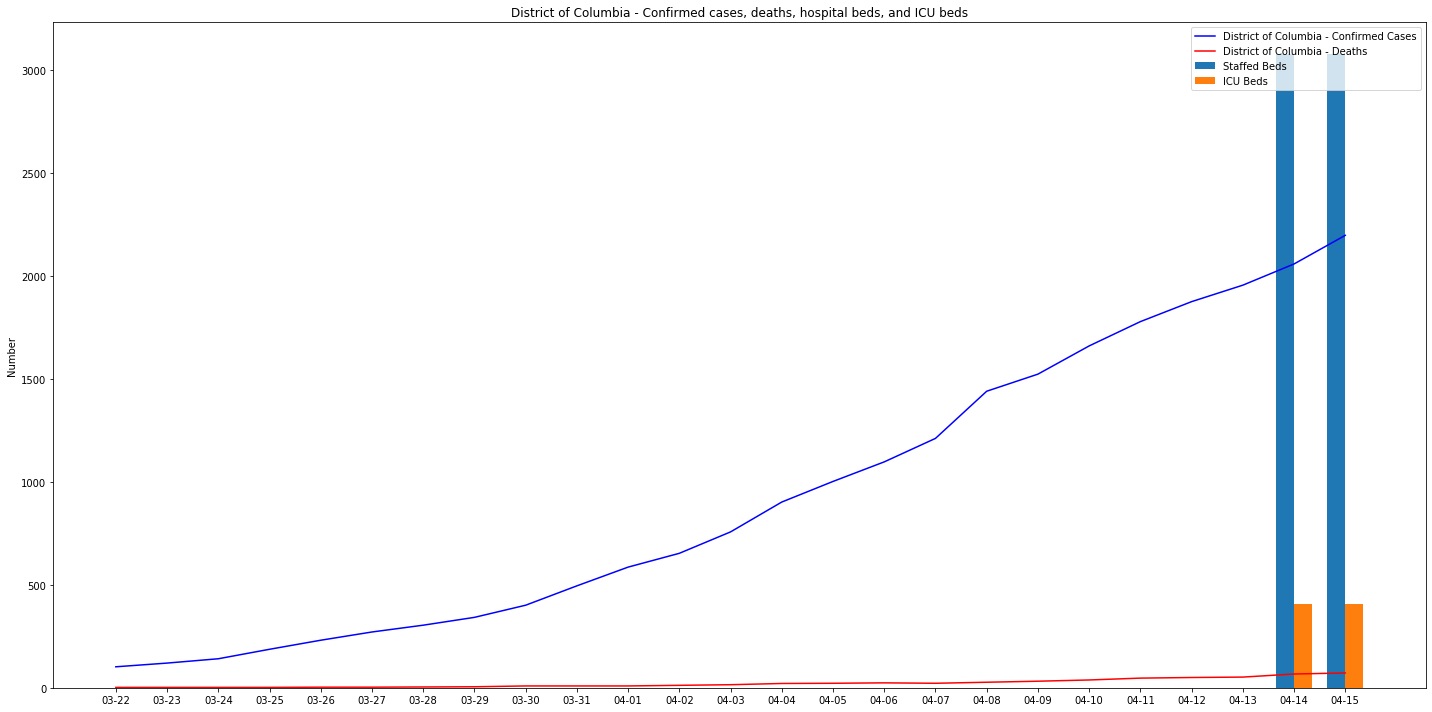

25
25


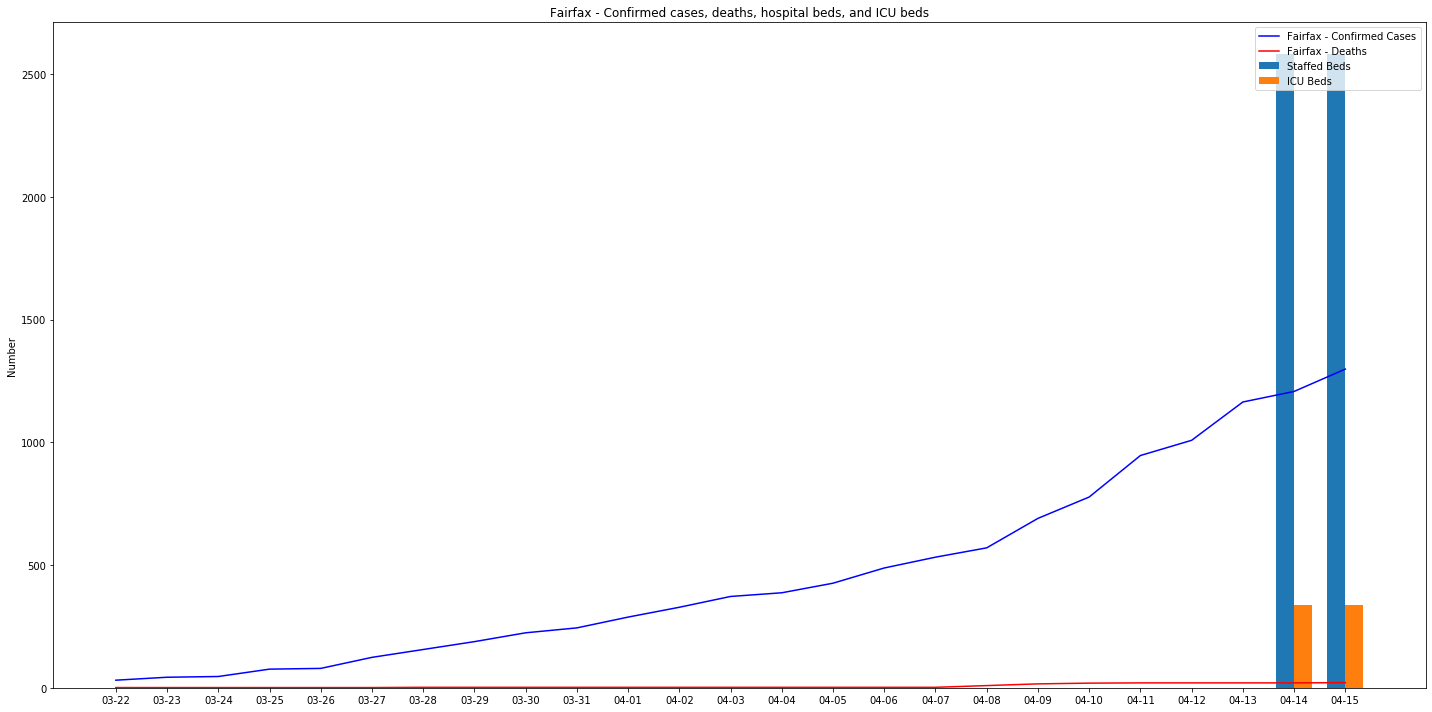

25
25


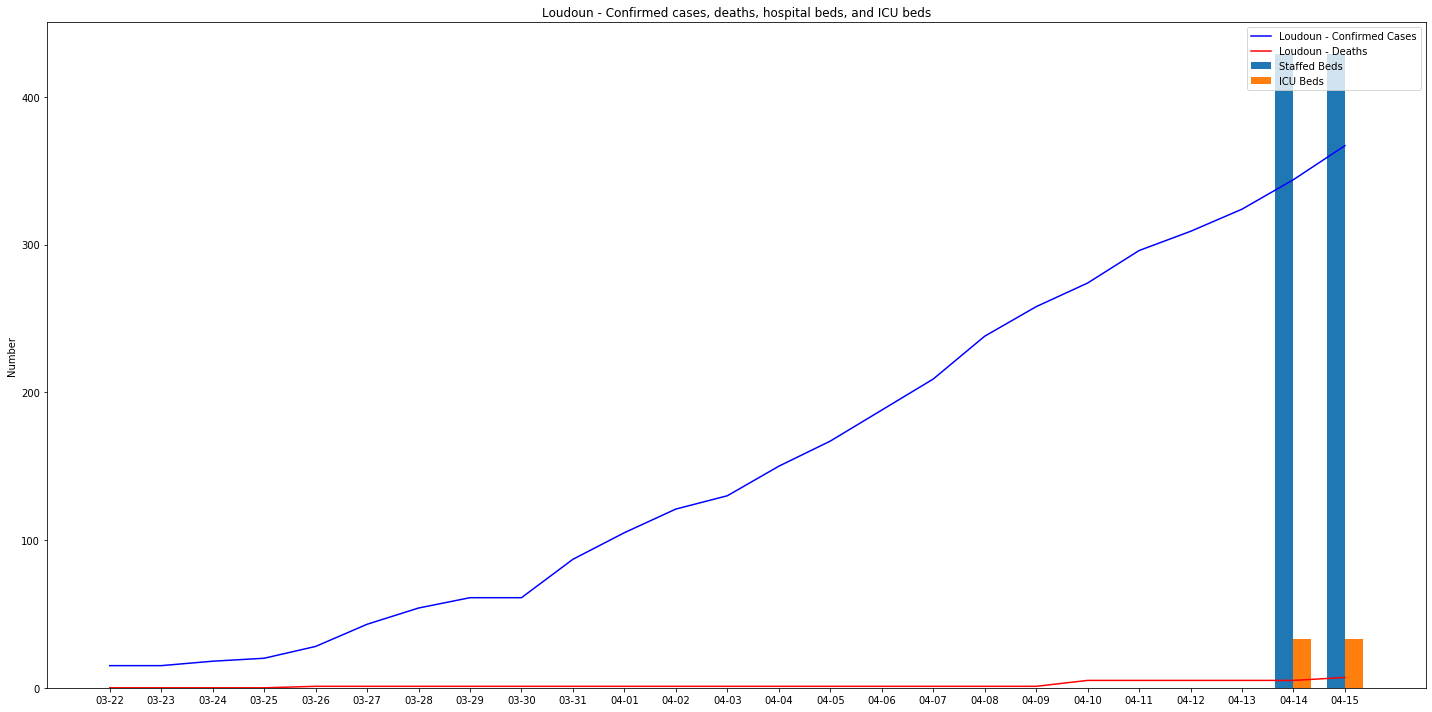

25
25


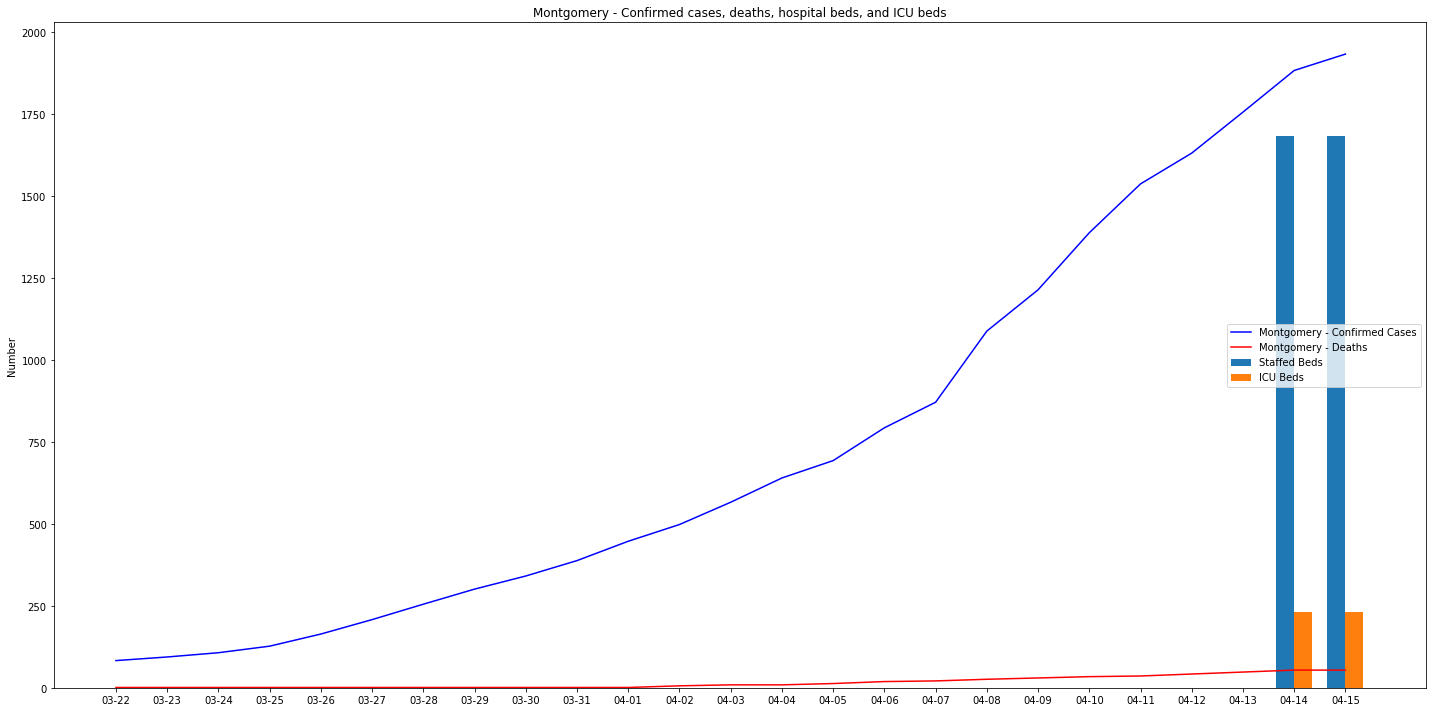

In [17]:
%local

width = 0.35

for index in df_counties.index:
    #print(index)
    
    county = df_counties.iloc[index].item()
#print(county)
    df_joined_county = df_dmv_joined_ordered.loc[df_dmv_joined_ordered['county']==county]
#print(df_joined_county)

#width = 0.35

    x_list = df_joined_county['date_posted'].tolist()
    x_list_map = map(lambda x: x.strftime("%m-%d"), x_list)
    x_list_dt = list(x_list_map)
    x = np.arange(len(x_list_dt))
#print(x_list_dt)
#print(len(x_list_dt))
    y_list_numConfirmed = df_joined_county['numConfirmed'].tolist()
    y_list_numDeaths = df_joined_county['numDeaths'].tolist()
    y_list_total_num_staffed_beds = df_joined_county['total_num_staffed_beds'].tolist()
    y_list_total_adult_icu_beds = df_joined_county['total_adult_icu_beds'].tolist()
    print(len(y_list_numConfirmed))
#print(y_list_numDeaths)
    print(len(y_list_total_num_staffed_beds))

    fig, ax = plt.subplots(figsize=(20,10))
    rects1 = ax.bar(x - width/2, y_list_total_num_staffed_beds, width, label='Staffed Beds')
    rects2 = ax.bar(x + width/2, y_list_total_adult_icu_beds, width, label='ICU Beds')

    ax.set_xticks(x)
    ax.set_xticklabels(x_list_dt)
    ax.set_ylabel('Number')
    ax.set_title(county + " - Confirmed cases, deaths, hospital beds, and ICU beds")
    ax.legend()
    fig.tight_layout()


    plt.plot(x_list_dt, y_list_numConfirmed, label=county + " - Confirmed Cases",color='blue')
    plt.plot(x_list_dt, y_list_numDeaths, label=county + " - Deaths",color='red')

    plt.text
    plt.legend()
    plt.show()